# AMME5710 Week 6 Tutorial

This activity is to be completed during the Week 6 tutorial. When you have completed the activity, you will need to show your results to the tutor who will check your work and that you have sufficiently completed the task: this needs to be completed during the tutorial time, so make sure you are ready to show the tutors your work during the last hour of the tutorial

**Tutorial Objectives and Instructions**:
- This tutorial will introduce you to concepts in image segmentation and explore methods for semi-supervised segmentation and unsupervised image segmentation routines based on image clustering.
- You should step through the example code snippets which explain and demonstrate the use of relevant functions in OpenCV.
- At the end of the notebook, there are several activities/exercises you will need to complete yourself. You can choose to:
    - Complete these inside the tutorial Jupyter Notebook using python code blocks
    - Write your own python code/scripts to produce the results requested

At any time, you can review the OpenCV documentation [https://docs.opencv.org/4.9.0/index.html](https://docs.opencv.org/4.9.0/index.html)l


In [2]:
# Import required modules
import cv2
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline 

## 1. K-means Clustering

K-means is a data clustering algorithm designed to split N data points into K clusters such that the within-cluster sum-of-squares distance is minimised. K-means can be used to segment the pixels in an image into K distinct classes based on colour, intensity, textural, spatial and/or other properties of the pixels themselves in an automated way.

OpenCV provides an implementation of k-means clustering via the function "cv2.kmeans":
```
(ret,labels,centers) = cv2.kmeans(data,K,init_labels,criteria,attempts,flags)
```

The function takes an N x M numpy array of input data points "data" (N points, each with M dimensions) and the number of clusters "K". "init_labels" should be set to "None" in the python interface for this function. "criteria" is a tuple of three values controlling the convergence of the algorithm, allowing the user to specify whether convergence is based on number of iterations or accuracy in the final clustering. The algorithm runs "attempts" number of times and stores the best clustering. Flags can be used to control options such as how the initial cluster centres are selected. The function returns the total cost of the clustering in "ret", a list of cluster index values for each point "labels", and the K cluster centers "centers".

To apply kmeans to cluster the pixel values in a colour image, you first need to convert the image data into a list of points (NxM) points, where N is the total number of image pixels, each with M different properties to cluster over. To cluster the image using the (R,G,B) colour values of each pixel (i.e. M=3):

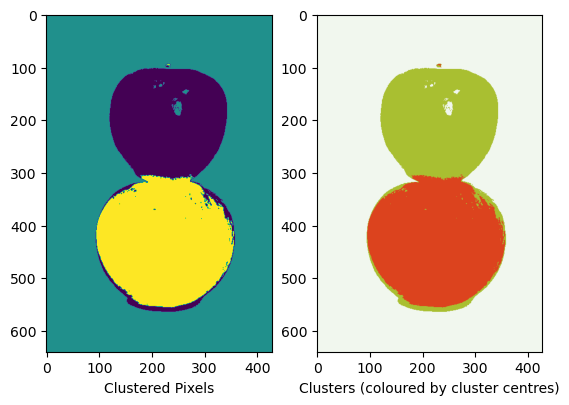

In [3]:
# Load image
img = cv2.imread('example_images_week6/apples.jpg')

# Convert image pixel data (RGB) into 2D array
pixel_data = np.float32(img.reshape((-1,3)))

# K-means clustering
K = 3
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
(ret,labels,centers) = cv2.kmeans(pixel_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Reshape to create image with cluster IDs
label_img = labels.reshape((img.shape[:2]))

# Create image where colours correspond to the cluster center values (RGB) of corresponding cluster
centers = np.uint8(centers)
label_img2 = centers[labels.flatten()].reshape((img.shape))

plt.subplot(121)
plt.imshow(label_img) # apply standard colourmap to label numbers
plt.xlabel('Clustered Pixels')

plt.subplot(122)
plt.imshow(cv2.cvtColor(label_img2, cv2.COLOR_BGR2RGB))
plt.xlabel('Clusters (coloured by cluster centres)')

plt.show()

It is also possible to colour image pixels based on different properties: different colour space might be used to cluster pixels, or pixels might also be clustered based on their spatial coordinates (i.e. (x,y)) as well as value/colour.

## 2. Interactive Image Segmentation using Grabcut

“GrabCut” is an interactive segmentation method that uses a collection of “seed” image locations corresponding to foreground or background objects and uses these seeds in a graph energy-based optimisation algorithm to segment a foreground object from a background one. The approach enables a user to incrementally improve a segmentation result from an initial segmentation by progressively adding foreground and background labels.

OpenCV provides a function "cv2.grabcut" which can be used to perform this segmentation on an image "img", and can operate in several different ways:
```
output = cv2.grabCut(img,mask,rect,bgModel,fgModel,iterCount,mode)
```
"iterCount" specifies the number of iteration the algorithm should run for, and mode specifies how the segmentation should proceed.

For mask-based segmentation, "mask" is a user-provided mark which contains information about the regions of the image that "seed" the algorithm: this is an integer-valued mask, where values of 0 (cv2.GC_BGD) correspond to labelled background and 1 (cv2.GC_FGD) to labelled foreground. This mask corresponds to locations where the user has draw examples of foreground/background pixels. Pixels which are not labelled/uncertain are given a value of 3 (cv2.GC_PR_FGD). When using a mask, the arguments "rect/bgModel/fgModel" are set to "None", and "mode" is set to "cv2.GC_INIT_WITH_MASK", e.g.:
```
output = cv2.grabCut(img,mask,None,None,None,iterCount,mode=cv2.GC_INIT_WITH_MASK)
```
"output" is a tuple of values (output_mask, bgModel, fgModel), where "output_mask" is the corresponding segmentation/clustering of each pixel, and "bgModel/fgModel" are (65x1) arrays representing the clusters of background/foreground pixels used to distinguish un-labelled pixels. Pixels in "output_mask" contain values between 0-3, where 0/1 correspoind to the labelled background/foreground, 2 (cv2.GC_PR_BGD) indicates possible/predicted background pixels, and 3 (cv2.GC_PR_FGD) indicates possible/predicted foreground pixels.

Grabcuts can also work via providing a bounding box "rect" (tuple of (x,y,w,h)) which specifies where the foreground object is: pixels outside of this box will be labelled as background, and pixels inside will be labelled as unknown/possible foreground (a value of 3 (cv2.GC_PR_FGD)). When using a rect, the arguments "mask/bgModel/fgModel" are set to "None", and "mode" is set to "cv2.GC_INIT_WITH_RECT", e.g.:
```
output = cv2.grabCut(img,None,rect,None,None,iterCount,mode=cv2.GC_INIT_WITH_RECT)
```
Finally, Grabcut also has a mode that allows you to provide pre-specified cluster centers for the background and foreground classes, which can be used to segment the image ("mode=cv2.GC_EVAL_FREEZE_MODEL"). In this mode "bgModel/fgModel" are (65x1) arrays representing the cluster centers of background/foreground pixels: these could be taken for example from an existing segmentation on a similar image. When using this mode, "rect" is set to None and the "mask" is provided with an empty zero-valued mask, which is used as working memory internally by the algorithm:
```
output = cv2.grabCut(img,mask,None,bgModel,fgModel,iterCount,mode=cv2.GC_EVAL_FREEZE_MODEL)
```


## Example

In the below example we look at performing background/foreground segmentation of the example image "chata.jpg". In this example, we will try to segment the house as the foreground object, with other parts of the environment (sky/rocks etc.) as background.

We begin by loading an image to be segmented, as well as a pre-filled mask which contains examples of background/foreground pixels that have been labelled by a user in "chata_mask001.png". These represent an initial set of labels provided at the first stage of masking.

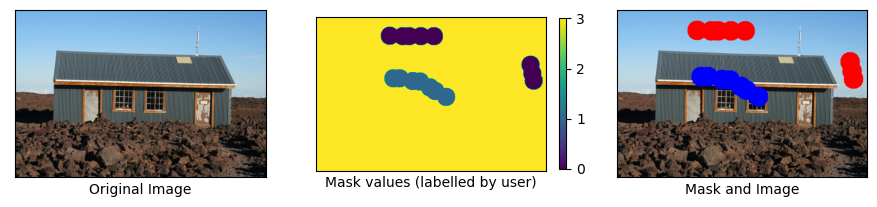

In [4]:
# Load example image (chata.jpg)
img = cv2.imread('example_images_week6/chata.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) # re-size by 50% for performance

# Load pre-drawn mask
mask = cv2.imread('example_images_week6/chata_mask001.png',cv2.IMREAD_GRAYSCALE) # pre-scalled
mask[mask==0] = cv2.GC_BGD # definite/labelled background (0)
mask[mask==64] = cv2.GC_FGD # definite/labelled foreground (1)
mask[mask==128] = cv2.GC_PR_BGD # possible background (2)
mask[mask==255] = cv2.GC_PR_FGD # possible foreground (3)

# render mask value over image
img2 = img.copy()
img2[mask==0] = (255,0,0) # background in red
img2[mask==1] = (0,0,255) # foreground in blue

plt.figure(figsize=(11,7))
plt.subplot(131)
plt.imshow(img) 
plt.xlabel('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(132)
plt.imshow(mask) # apply standard colourmap to label numbers
plt.colorbar(fraction=0.03)
plt.xlabel('Mask values (labelled by user)')
plt.xticks([]), plt.yticks([])

plt.subplot(133)
plt.imshow(img2)
plt.xlabel('Mask and Image')
plt.xticks([]), plt.yticks([])

plt.show()

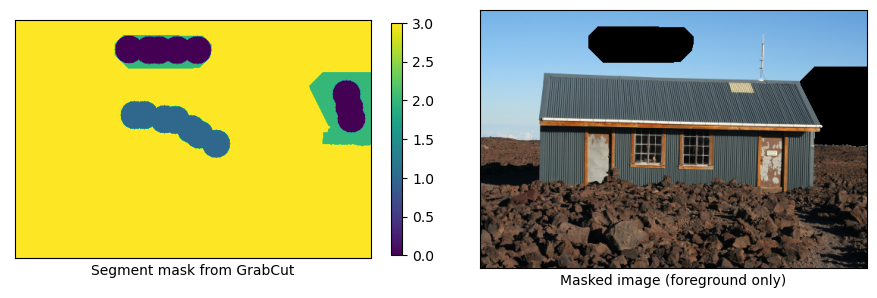

In [5]:
# Now run Grabcuts to segment the image using the provided label mask
output = cv2.grabCut(img, mask.copy(), None, None, None, iterCount=10, mode=cv2.GC_INIT_WITH_MASK)
(mask_out, bgModel, fgModel) = output

# display result
output_mask = np.logical_or((mask_out == cv2.GC_FGD),(mask_out == cv2.GC_PR_FGD))
output_mask = (output_mask * 255).astype('uint8')
output_img = cv2.bitwise_and(img, img, mask=output_mask)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.imshow(mask_out) # apply standard colourmap to label numbers
plt.colorbar(fraction=0.03)
plt.xlabel('Segment mask from GrabCut')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(output_img)
plt.xlabel('Masked image (foreground only)')
plt.xticks([]), plt.yticks([])

plt.show()


We have managed to segment away the sky from the house, but the rocks on the ground are still being segmented as part of the foreground. This could be improved if we provided some background labels that cover the rocks.

We will load in a slightly more extensive set of labels in the pre-filled label mask "chata_mask002.png":

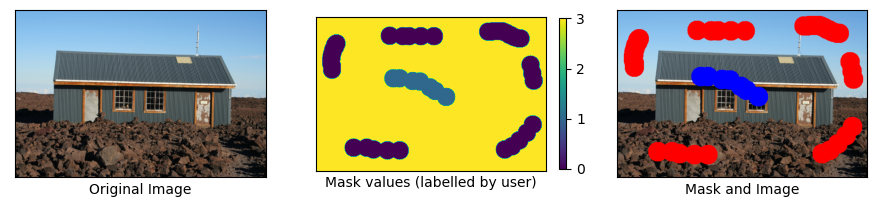

In [6]:
# Load better pre-drawn mask
mask = cv2.imread('example_images_week6/chata_mask002.png',cv2.IMREAD_GRAYSCALE) # pre-scalled
mask[mask==0] = cv2.GC_BGD # definite/labelled background (0)
mask[mask==64] = cv2.GC_FGD # definite/labelled foreground (1)
mask[mask==128] = cv2.GC_PR_BGD # possible background (2)
mask[mask==255] = cv2.GC_PR_FGD # possible foreground (3)

# render mask value over image
img2 = img.copy()
img2[mask==0] = (255,0,0) # background in red
img2[mask==1] = (0,0,255) # foreground in blue

plt.figure(figsize=(11,7))
plt.subplot(131)
plt.imshow(img) 
plt.xlabel('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(132)
plt.imshow(mask) # apply standard colourmap to label numbers
plt.colorbar(fraction=0.03)
plt.xlabel('Mask values (labelled by user)')
plt.xticks([]), plt.yticks([])

plt.subplot(133)
plt.imshow(img2)
plt.xlabel('Mask and Image')
plt.xticks([]), plt.yticks([])

plt.show()

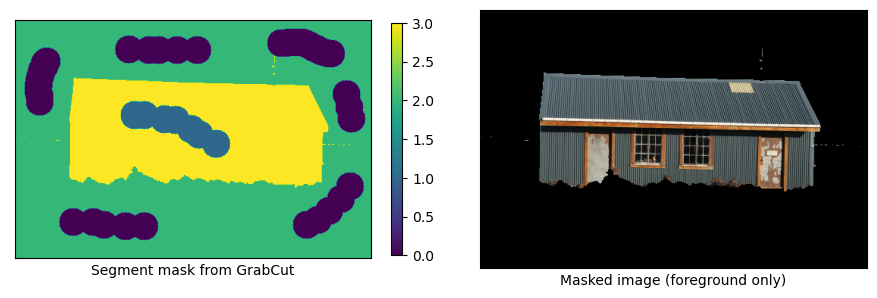

In [7]:
# Now re-perform Grabcuts to segment the image using the provided label mask
output = cv2.grabCut(img, mask.copy(), None, None, None, iterCount=10, mode=cv2.GC_INIT_WITH_MASK)
(mask_out, bgModel, fgModel) = output

# display result
output_mask = np.logical_or((mask_out == cv2.GC_FGD),(mask_out == cv2.GC_PR_FGD))
output_mask = (output_mask * 255).astype('uint8')
output_img = cv2.bitwise_and(img, img, mask=output_mask)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.imshow(mask_out) # apply standard colourmap to label numbers
plt.colorbar(fraction=0.03)
plt.xlabel('Segment mask from GrabCut')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(output_img)
plt.xlabel('Masked image (foreground only)')
plt.xticks([]), plt.yticks([])

plt.show()

## OpenCV GUI code for Interactive Segmentation

On the Week 6 Canvas page, the script file "grabcut_interactive.py" implements a simple interactive GUI that incorporates a drawing tool for labelling images and can run interactive segmentation using Grabcut. When you run the script, there are two windows that will load: the first allows you to click to draw labels, and the second displays the output of the segmentation.

Use the "f" key to toggle between foreground (blue) and background (red) labelling modes. Use the "a" key to run the segmentation given the current labels. Press escape to quit.

At the bottom of the source code there is also a segment of commented code that allows you to save out the final mask that your drew (in a similar format to the mask images shown above).

# Exercise/Activities to Complete
The following activities should be completed during the Friday tutorial and shown to your tutor to be marked off.


## Exercise 1: K-means Clustering

- Develop code to perform image segmentation based on k-means colour clustering for a user-selectable value of K
- Experiment with the performance of this segmentation approach in the example images by varying K. Try varying the input colour space of the image array (i.e. see colour transformations in Week 2) prior to clustering and note the way in which data is clustered differently in different colour spaces
- Produce plots that show the clustered points in the three dimensions of the colour space, and also how these clusters appear in the image space.
- Extend your approach to include a spatial layer: to do this, add columns to the data matrix in points that represent the x and y locations of each pixel in the data point list, and include these in the clustering (so your input data to cluster should have M=5 (R,G,B,x,y)) (Note: thr R,G,B could be converted to an alternative colour space).
- Note that the range of values (in feature space) of the spatial dimensions are different to the 0-255 colour space values provided by the RGB dimensions, depending on image size and resolution. You will need to scale your spatial values to control the degree to which clusters lock onto colour/spatial/textural properties (i.e. if these dimensions have a range that is greater than 0-255, more emphasis will be put on segmenting these dimensions, and having numbers that have a smaller range than 0-255 will put less emphasis with respect to colour.


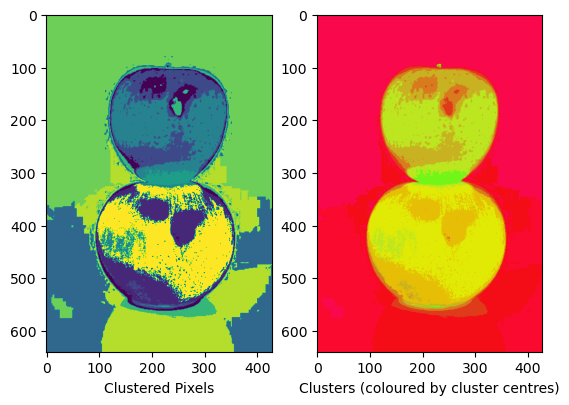

In [8]:
# Write your code here, or in a separate python script - IN HSV

# Load image
img = cv2.imread('example_images_week6/apples.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Convert image pixel data (RGB) into 2D array
pixel_data = np.float32(img.reshape((-1,3)))

# K-means clustering
K = 10
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
(ret,labels,centers) = cv2.kmeans(pixel_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Reshape to create image with cluster IDs
label_img = labels.reshape((img.shape[:2]))

# Create image where colours correspond to the cluster center values (RGB) of corresponding cluster
centers = np.uint8(centers)
label_img2 = centers[labels.flatten()].reshape((img.shape))



plt.subplot(121)
plt.imshow(label_img) # apply standard colourmap to label numbers
plt.xlabel('Clustered Pixels')

plt.subplot(122)
plt.imshow(cv2.cvtColor(label_img2, cv2.COLOR_BGR2RGB))
plt.xlabel('Clusters (coloured by cluster centres)')

plt.show()


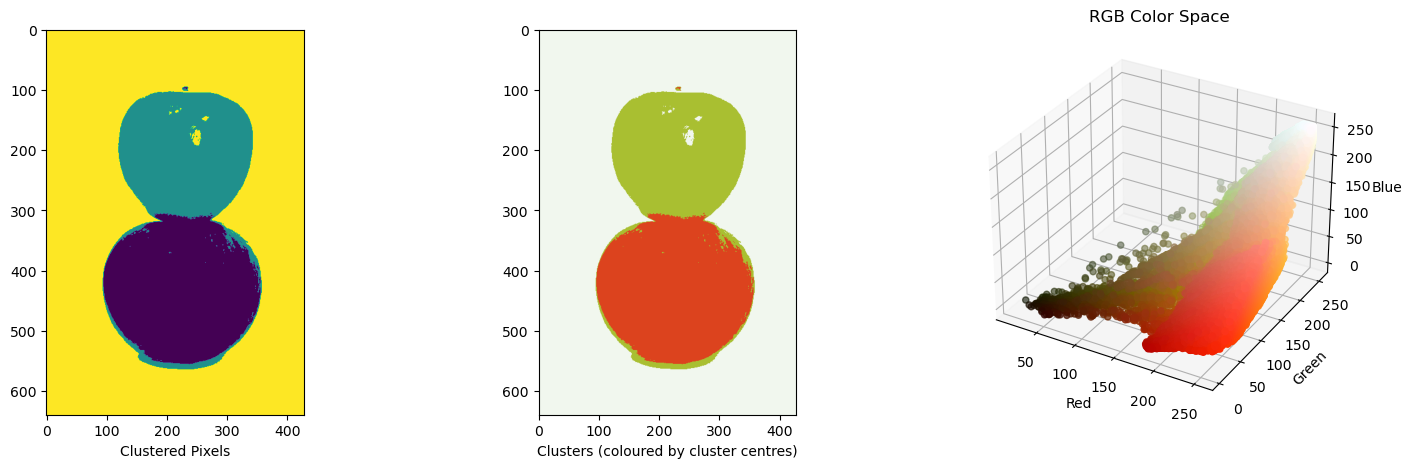

In [35]:
# Write your code here, or in a separate python script - RGB 

# Load image
img = cv2.imread('example_images_week6/apples.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert image pixel data (RGB) into 2D array
pixel_data = np.float32(img.reshape((-1,3)))

# K-means clustering
K = 3
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
(ret,labels,centers) = cv2.kmeans(pixel_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Reshape to create image with cluster IDs
label_img = labels.reshape((img.shape[:2]))

# Create image where colours correspond to the cluster center values (RGB) of corresponding cluster
centers = np.uint8(centers)
label_img2 = centers[labels.flatten()].reshape((img.shape))


fig = plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.imshow(label_img) # apply standard colourmap to label numbers
plt.xlabel('Clustered Pixels')

plt.subplot(132)
plt.imshow(label_img2)
plt.xlabel('Clusters (coloured by cluster centres)')

pixels = pixel_data.reshape(-1, 3)
pixel_colors = img.reshape(-1, 3)


ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixel_colors / 255.0)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('RGB Color Space')

plt.show()


(640, 428)
(273920, 1)
[[225 238 231]
 [226 239 232]
 [226 239 232]
 ...
 [233 241 228]
 [234 242 229]
 [234 242 229]]


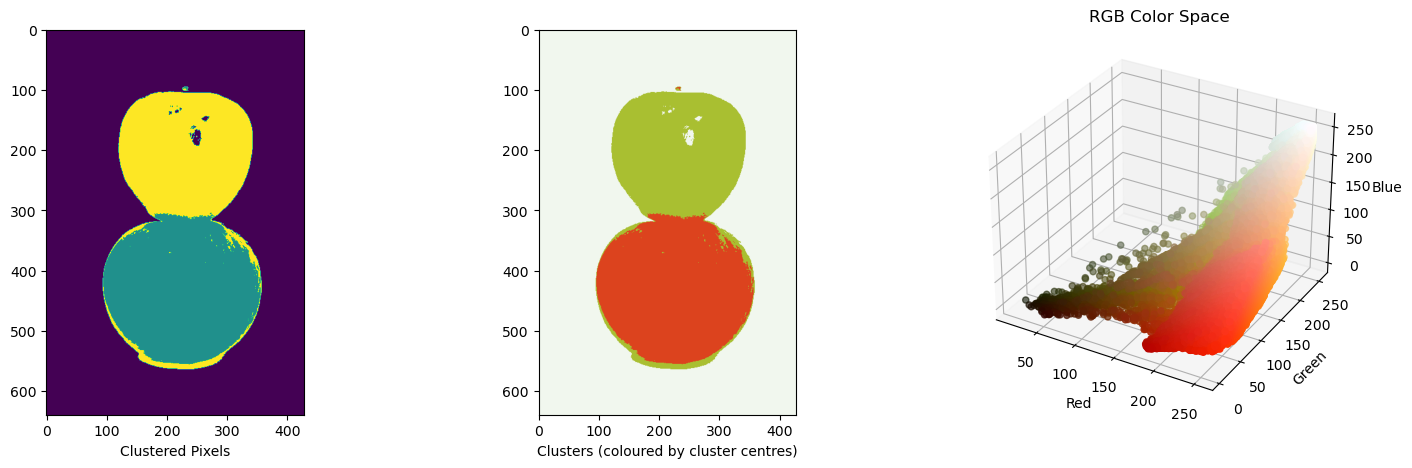

In [ ]:
# Add spatial layer 

# Load image
img = cv2.imread('example_images_week6/apples.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape

# Convert image pixel data (RGB) into 2D array
pixel_data = np.float32(img.reshape((-1,3)))

# Find coordinate data and scale 
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))

# scale spatial from zero to one to have equal controbution to RGB values 
x_coords = (x_coords / w) * 1
y_coords = (y_coords / h) * 1

print(x_coords.shape)
x_coords = x_coords.reshape((-1,1)).astype(np.float32)
y_coords = y_coords.reshape((-1,1)).astype(np.float32)

print(x_coords.shape)


# Create 5D vector of data 
pixel_data = np.hstack((pixel_data, x_coords, y_coords))


# K-means clustering
K = 3
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
(ret,labels,centers) = cv2.kmeans(pixel_data,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Reshape to create image with cluster IDs
label_img = labels.reshape((img.shape[:2]))

# Create image where colours correspond to the cluster center values (RGB) of corresponding cluster
centers = np.uint8(centers[:, :3])
label_img2 = centers[labels.flatten()].reshape((img.shape))


fig = plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.imshow(label_img) # apply standard colourmap to label numbers
plt.xlabel('Clustered Pixels')

plt.subplot(132)
plt.imshow(label_img2)
plt.xlabel('Clusters (coloured by cluster centres)')

pixels = pixel_data.reshape(-1, 5)
pixel_colours = img.reshape(-1, 3)

print(pixel_colours)


ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixel_colours/255.0)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('RGB Color Space')

plt.show()


## Exercise 2: Interactive Segmentation

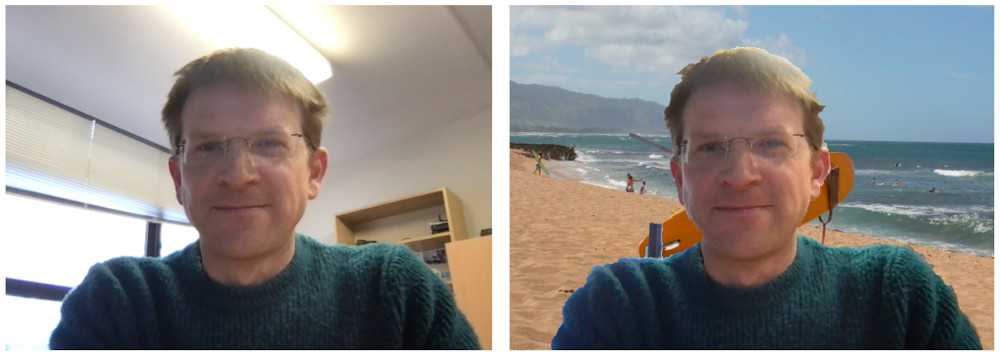

- Load up some of the images found in this week’s examples. Generate your own label mask for some of the images and use Grabcuts to segment images into foreground and background classes. You might also like to use the "grabcut_interactive.py" script to experiment with labels and also use this to export the final masks that you have drawn.
- **Develop code for a faux-Zoom backdrop**: Take an image of yourself (perhaps using your webcam) (or see the image "webcam_mitch.png") and try to develop code to automatically segment the person sitting in front of the camera from the background using Grabcuts. Add a nice image of your choice to compose into the background (e.g. see above).
- To do this, create a mask and specify a region in the center bottom of the image that is labelled "foreground", and regions in the top corners of the image that are labelled "background": i.e. where you expect to find (and not find) the person sitting in front of the camera.
- Show your automatically proposed mask pixels and final segmented image.
- **Optional Extension**: you might like to try and get this approach to work across multiple webcam frames: try using the first image plus labels to segment the image while keeping the "bgModel/fgModel". For subsequent frames, try running the segmentation using these clusters via "mode=cv2.GC_EVAL_FREEZE_MODEL".


(304, 404, 3)
(304, 404)


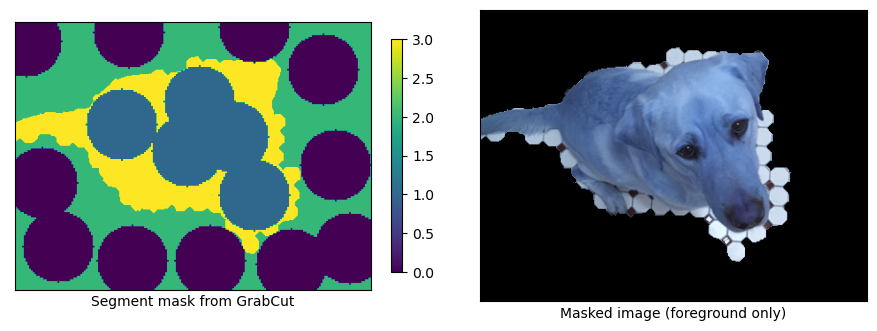

In [36]:
# Write your code here, or in a separate python script
# img = cv2.imread('example_images_week6/webcam_mitch.png')
# mask = cv2.imread('mitch_mask.png', cv2.IMREAD_GRAYSCALE)
# mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


img = cv2.imread('example_images_week6/dog.png')
mask = cv2.imread('dog_mask.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# img = cv2.imread('example_images_week6/xhand.jpg')
# mask = cv2.imread('hand_mask.png', cv2.IMREAD_GRAYSCALE)
# mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)


print(img.shape)
print(mask.shape)

mask[mask==0] = cv2.GC_BGD # definite/labelled background (0)
mask[mask==64] = cv2.GC_FGD # definite/labelled foreground (1)
mask[mask==128] = cv2.GC_PR_BGD # possible background (2)
mask[mask==255] = cv2.GC_PR_FGD # possible foreground (3)

output = cv2.grabCut(img, mask.copy(), None, None, None, iterCount=10, mode=cv2.GC_INIT_WITH_MASK)
(mask_out, bgModel, fgModel) = output

# display result
output_mask = np.logical_or((mask_out == cv2.GC_FGD),(mask_out == cv2.GC_PR_FGD))
output_mask = (output_mask * 255).astype('uint8')
output_img = cv2.bitwise_and(img, img, mask=output_mask)

plt.figure(figsize=(11,7))
plt.subplot(121)
plt.imshow(mask_out) # apply standard colourmap to label numbers
plt.colorbar(fraction=0.03)
plt.xlabel('Segment mask from GrabCut')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(output_img)
plt.xlabel('Masked image (foreground only)')
plt.xticks([]), plt.yticks([])

plt.show()




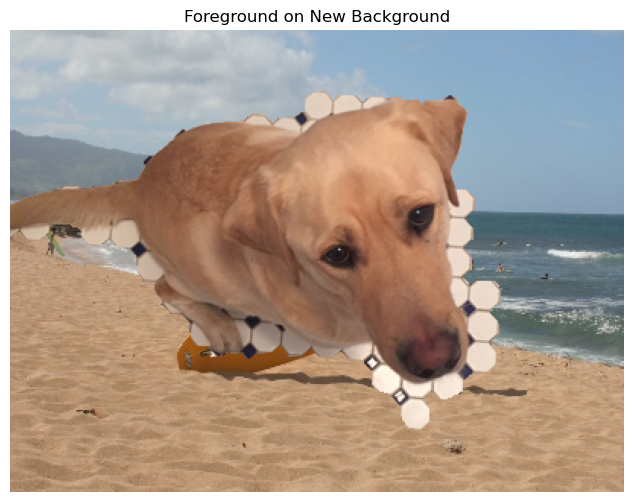

In [37]:
# Add to background 

# Load your new background image
background = cv2.imread('example_images_week6/beach.jpg')
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Resize background to match img size (if needed)
background = cv2.resize(background, (img.shape[1], img.shape[0]))

# Create inverse mask (background area = 255, foreground area = 0)
inv_mask = cv2.bitwise_not(output_mask)

# Extract background region where foreground will NOT be placed
bg_region = cv2.bitwise_and(background, background, mask=inv_mask)

output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Combine foreground and background
combined = cv2.add(bg_region, output_img)

# Show combined result
plt.figure(figsize=(8, 6))
plt.imshow(combined)
plt.axis('off')
plt.title('Foreground on New Background')
plt.show()


[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


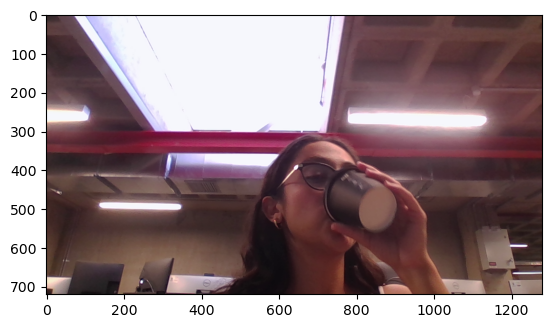

In [13]:
# Note on capturing images from your webcam using OpenCV:

# Capture a frame from a webcam (only works on locally-running notebooks)
cam = cv2.VideoCapture(0) # looks for device "0" (probably your webcam)
ret_val, img = cam.read()
#img = cv2.flip(img, 1) # You might want to flip for a mirror-like view
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))